<a href="https://colab.research.google.com/github/MadsAndersens/ColorizingGrayscaleImagesPlaceHolder/blob/main/Colorizing_Grayscale_Images_Athletic_Field.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#look at https://github.com/voletiv/self-attention-GAN-pytorch/blob/master/trainer.py

In [ ]:
!sudo apt-get install -y bsdtar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
bsdtar is already the newest version (3.2.2-3.1ubuntu0.6).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
from IPython.display import display, clear_output
from matplotlib import pyplot as plt
plt.style.use('dark_background')
import numpy as np
import torch
import cv2
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from  glob import glob
#from PIL import Image
#from skimage import color
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
#http://data.csail.mit.edu/places/places365/train_256_split/a.tar

if not os.path.exists('./data_256/'):
  !wget -O- http://data.csail.mit.edu/places/places365/train_256_places365standard.tar | bsdtar -xkf-

In [ ]:
#@title Parameters {display-mode: "form"}
#@markdown ---
batch_size = 32 #@param {type: "number"}
disc_iters =  1#@param {type: "number"}
plot_iter = 10 #@param {type: "number"}
#@markdown ---
D_lr = 5e-5 #@param {type: "number"}
G_lr = 5e-5 #@param {type: "number"}

beta_1 = 0.9 #@param {type: "number"}
beta_2 = 0.999 #@param {type: "number"}
G_betas = D_betas = (beta_1, beta_2) #ONLY FOR ADAM
#@markdown ---
training_opt = 'R1_GP'#@param ["None","R1_reg", "GP", "R1_GP"]
R1_reg = 1 #@param {type: "slider", min: 0.0, max: 100.0, step: 0.1}
instance_noise_iter = 2000 #@param {type: "slider", min: 0.0, max: 20000, step: 100}
instance_smoothing = True #@param {type: "boolean"}
#@markdown ---
#Training options for reconstruction loss
recon_type = 'mse' #@param ["None", "huber", "mse"]
recon_lambda = 1 #@param [0.1,0.2,0.2,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.5,2.0,5.0,10.0,25.0,50.0,100.0,200.0] {type:"raw"}
#@markdown ---
upsample_type = "Bilinear" #@param ["PixelShuffle", "Bilinear"]

In [ ]:
min_size = 256
crop_size = 128
if not os.path.exists(f'./{min_size}_sized_images.txt'):
  with open(f'./{min_size}_sized_images.txt', 'w+') as f:
    for p in tqdm(glob('data_256/a/athletic_field/outdoor/*.jpg')):
      print(p, file=f)

In [ ]:
hyper_params = {}
hyper_params['batch_size']=batch_size
hyper_params['disc_iters']=disc_iters
hyper_params['plot_iter']=plot_iter
hyper_params['D_lr']=D_lr
hyper_params['G_lr']=G_lr
hyper_params['beta_1']=beta_1
hyper_params['beta_2']=beta_2
hyper_params['training_opt']=training_opt
hyper_params['R1_reg']=R1_reg
hyper_params['instance_noise_iter']=instance_noise_iter
hyper_params['instance_smoothing']=instance_smoothing
if recon_type in ['mse', 'huber']:
  hyper_params['recon_type']=recon_type
  hyper_params['recon_lambda']=recon_lambda
hyper_params['upsample_type']=upsample_type

In [ ]:
resize_crop_transform = transforms.Compose([transforms.Resize(min_size),transforms.RandomCrop(crop_size)])
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, transform):
      with open(f'./{min_size}_sized_images.txt', 'r') as f:
        self.image_paths = f.read().splitlines()
      self.transform = transform

    def __len__(self):
      return len(self.image_paths)

    def __getitem__(self, idx):
      im = cv2.imread(self.image_paths[idx])
      #im_RGB = torch.tensor(cv2.cvtColor(im, cv2.COLOR_BGR2RGB) / 255.0, dtype=torch.float).permute(2,0,1)
      im_Lab = torch.tensor(cv2.cvtColor(im, cv2.COLOR_BGR2Lab) / 255.0, dtype=torch.float).permute(2,0,1)
      #im = self.transform(torch.cat([im_Lab, im_RGB],0))
      im = self.transform(im_Lab)
      return im

dataset = CustomDataset(transform=resize_crop_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
print(len(dataset))

5000


In [ ]:
def Lab2RGB(im):
  if im.shape[0] == 3:
    im = im.permute(1,2,0)
  im = 255.0*im
  im = im.to(torch.uint8).numpy()
  return cv2.cvtColor(im, cv2.COLOR_Lab2RGB)

(-0.5, 1041.5, 1041.5, -0.5)

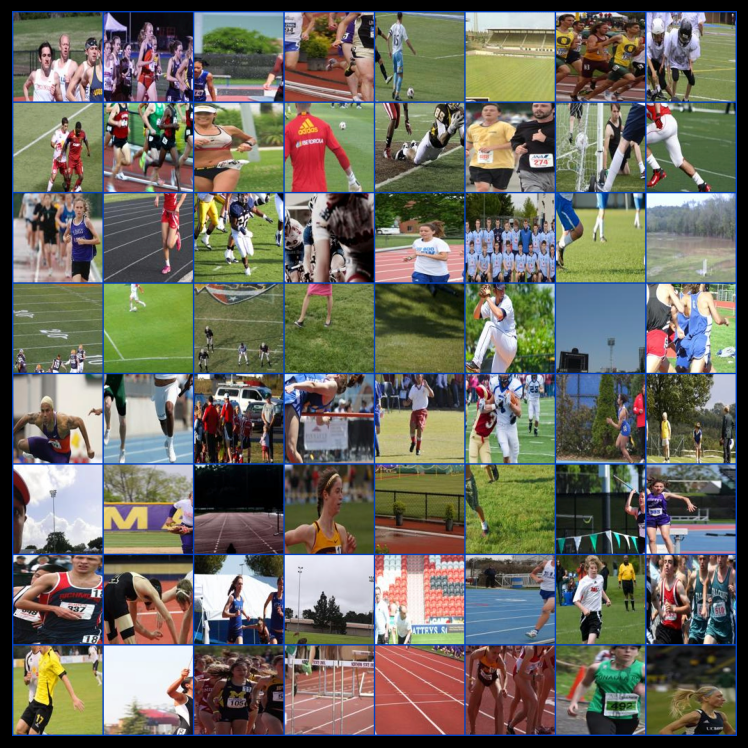

In [ ]:
plt.figure(figsize=(8,8), dpi=120)
plt.imshow(Lab2RGB(torchvision.utils.make_grid([dataset[i] for i in range(8*8)],8).cpu()))
plt.axis('off')

In [ ]:
class PixelShuffleUpsample(torch.nn.Module):
  def __init__(self, in_channels, factor):
    super(PixelShuffleUpsample, self).__init__()
    self.conv = nn.Conv2d(in_channels, int(in_channels*factor**2), kernel_size=3, stride=1, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(factor)
  def forward(self, x):
    return self.pixel_shuffle(self.conv(x))

class AdaIN(torch.nn.Module):
  def __init__(self, out_channels):
    super(AdaIN, self).__init__()
    self.out_channels = out_channels
    self.StyleMapping_mean = nn.Linear(512, out_channels)
    self.StyleMapping_scale = nn.Linear(512, out_channels)


  def forward(self, x, latent):
    style_scale = self.StyleMapping_scale(latent).unsqueeze(-1).unsqueeze(-1)
    style_mean = self.StyleMapping_mean(latent).unsqueeze(-1).unsqueeze(-1)
    scale = style_scale/x.std((-2,-1), keepdim=True)
    mean = x.mean((-2,-1), keepdim=True)
    x = scale*(x-mean)+style_mean
    return x

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

class ConvBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, n_intermediate_layers=1, direction='in'):
    super(ConvBlock, self).__init__()
    if direction == 'out':
      self.BlockLayers = nn.Sequential(nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
                                       nn.GELU(),
                                       *[l for _ in range(n_intermediate_layers) for l in [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),nn.GELU()]])
    else:
      self.BlockLayers = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                                       nn.GELU(),
                                       *[l for _ in range(n_intermediate_layers) for l in [nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),nn.GELU()]])
  def forward(self, x):
    x = self.BlockLayers(x)
    return x

class EncoderBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, n_intermediate_layers=1):
    super(EncoderBlock, self).__init__()
    self.EncoderBlock = ConvBlock(in_channels, out_channels, n_intermediate_layers, direction='in')
    self.MaxPool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.EncoderBlock(x)
    skip = x
    x = self.MaxPool(x)
    return x, skip

class DecoderBlock(torch.nn.Module):
  def __init__(self, in_channels, out_channels, n_intermediate_layers=1):
    super(DecoderBlock, self).__init__()
    if upsample_type == 'PixelShuffle':
      self.UpSample = PixelShuffleUpsample(in_channels,2)#
    else:
      self.UpSample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
    self.DecoderBlock = ConvBlock(in_channels, out_channels, n_intermediate_layers, direction='out')

  def forward(self, x, skip):
    x = self.UpSample(x)
    x = self.DecoderBlock(x + skip)
    return x


In [ ]:
#Unet Basic
class GeneratorUNet(torch.nn.Module):
  def __init__(self):
    super(GeneratorUNet, self).__init__()
    #Latent mappings
    self.MappingNetwork = nn.Sequential(
                          nn.Linear(512,512),
                          nn.ReLU(True),
                          nn.Linear(512,512),
                          nn.ReLU(True),
                          nn.Linear(512,512),
                          nn.ReLU(True))

    #Encoder Mapping
    self.enc_block1 = EncoderBlock(1,128,2)   #128 -> 64
    self.enc_block2 = EncoderBlock(128,256,1) #64  -> 32
    self.enc_block3 = EncoderBlock(256,512,1) #32  -> 16
    self.enc_block4 = EncoderBlock(512,512,1) #16  -> 8
    self.enc_block5 = EncoderBlock(512,512,0) #8   -> 4
    self.enc_block6 = EncoderBlock(512,512,0) #4   -> 2
    self.enc_block7 = EncoderBlock(512,512,0) #2   -> 1

    #Skip connection AdaINS
    self.skip_AdaIN1 = AdaIN(128)
    self.skip_AdaIN2 = AdaIN(256)
    self.skip_AdaIN3 = AdaIN(512)
    self.skip_AdaIN4 = AdaIN(512)
    self.skip_AdaIN5 = AdaIN(512)
    self.skip_AdaIN6 = AdaIN(512)
    self.skip_AdaIN7 = AdaIN(512)

    #Bottleneck
    self.bot_block1 = ConvBlock(512,512,1, direction='in') #16 -> 16

    #Encoder to Mapping Network
    self.enc2map_conv = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0)
    self.enc2map_linear = nn.Linear(512,512)
    self.enc2map_mixing = nn.Linear(512,512)

    self.bot_block2 = ConvBlock(512,512,1, direction='out') #16 -> 16

    #Decoder
    self.dec_block1 = DecoderBlock(512,512,0) #1   -> 2
    self.dec_block2 = DecoderBlock(512,512,0) #2   -> 4
    self.dec_block3 = DecoderBlock(512,512,0) #4   -> 8
    self.dec_block4 = DecoderBlock(512,512,0) #8   -> 16
    self.dec_block5 = DecoderBlock(512,256,1) #16  -> 32
    self.dec_block6 = DecoderBlock(256,128,1) #32  -> 64
    self.dec_block7 = DecoderBlock(128,128,1) #64  -> 128

    #Out
    self.out_conv = nn.Conv2d(128, 2, kernel_size=1, stride=1, padding=0, bias=True)


  def forward(self, gray, latent):
    #Latent mapping
    latent = self.MappingNetwork(latent)

    x = gray
    #x = torch.cat([x, torch.randn(x.size(0), 2, x.size(2), x.size(3), device=x.device)], 1)
    x, skip1 = self.enc_block1(x)
    x, skip2 = self.enc_block2(x)
    x, skip3 = self.enc_block3(x)
    x, skip4 = self.enc_block4(x)
    x, skip5 = self.enc_block5(x)
    x, skip6 = self.enc_block6(x)
    x, skip7 = self.enc_block7(x)

    #Bottleneck
    x = self.bot_block1(x)

    enc2map = F.gelu(self.enc2map_conv(x))
    enc2map = enc2map.view(enc2map.size(0),-1)
    enc2map = F.gelu(self.enc2map_linear(enc2map))
    latent = latent + enc2map
    latent = F.gelu(self.enc2map_mixing(latent))

    #Skip AdaINs
    skip1 = self.skip_AdaIN1(skip1, latent)
    skip2 = self.skip_AdaIN2(skip2, latent)
    skip3 = self.skip_AdaIN3(skip3, latent)
    skip4 = self.skip_AdaIN4(skip4, latent)
    skip5 = self.skip_AdaIN5(skip5, latent)
    skip6 = self.skip_AdaIN6(skip6, latent)
    skip7 = self.skip_AdaIN7(skip7, latent)

    x = self.bot_block2(x)

    #Decoder
    x = self.dec_block1(x, skip7)
    x = self.dec_block2(x, skip6)
    x = self.dec_block3(x, skip5)
    x = self.dec_block4(x, skip4)
    x = self.dec_block5(x, skip3)
    x = self.dec_block6(x, skip2)
    x = self.dec_block7(x, skip1)

    #Out
    out = torch.sigmoid(self.out_conv(x))
    out = torch.cat([gray, out],1)
    return out


GNet = GeneratorUNet().to(device)
GNet.apply(weights_init)
#print(GNet)
print("Generator trainable parameters:", sum(p.numel() for p in GNet.parameters() if p.requires_grad))

Generator trainable parameters: 44715906


In [ ]:
#Unet Basic
class DiscriminatorNet(torch.nn.Module):
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    resnet = models.resnet34()
    self.resnet = nn.Sequential(resnet.conv1, resnet.maxpool, resnet.relu, resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4)

    # # #Encoder
    # self.enc_conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
    # self.enc_conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
    # self.enc_down1 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)

    # self.enc_conv3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    # self.enc_conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
    # self.enc_down2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)

    # self.enc_conv5 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
    # self.enc_conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    #Out
    #self.out_conv = nn.Conv2d(512, 1024, kernel_size=1, stride=1, padding=0)

  def forward(self, x):
    # x = res = F.gelu(self.enc_conv1(x))#
    # x = res + F.gelu(self.enc_conv2(x))#
    # x = res = F.gelu(self.enc_down1(x))

    # x = res = res + F.gelu(self.enc_conv3(x))#
    # x = res = res + F.gelu(self.enc_conv4(x))#
    # x = res = F.gelu(self.enc_down2(x))

    # x = res = res + F.gelu(self.enc_conv5(x))#
    # x = res + F.gelu(self.enc_conv6(x))#

    # x = F.gelu(self.out_conv(x))
    return self.resnet(x)

DNet = DiscriminatorNet().to(device)
DNet.apply(weights_init)
#print(DNet)
print("Discriminator trainable parameters:", sum(p.numel() for p in DNet.parameters() if p.requires_grad))

Discriminator trainable parameters: 21284544


In [ ]:
def Lab2RGB(im):
  if im.shape[0] == 3:
    im = im.permute(1,2,0)
  im = 255.0*im
  im = im.to(torch.uint8).numpy()
  return cv2.cvtColor(im, cv2.COLOR_Lab2RGB)

def smooth(scalars, weight):
	last = scalars[0]
	smoothed = list()
	for point in scalars:
		smoothed_val = last * weight + (1 - weight) * point
		smoothed.append(smoothed_val)
		last = smoothed_val
	return smoothed

def anneal(val, target):
  return max((target-val)/target,0)

In [ ]:
from torch.cuda.amp.autocast_mode import autocast
#from torch.cuda.amp import GradScaler

from collections import defaultdict

G_optimizer = torch.optim.Adam(GNet.parameters(), lr=G_lr, betas=G_betas)
D_optimizer = torch.optim.Adam(DNet.parameters(), lr=D_lr, betas=D_betas)

losss_print = defaultdict(lambda: [])
print_to_legend = {
'Div.':r'Div.',
'G.i+1':r'$D(G_{i+1}(z|y))$',
'D.':r'$D(x)$',
'G.i':r'$D(G_{i}(z|y))$'
}

mse_loss_fn = nn.MSELoss()
huber_loss_fn = nn.SmoothL1Loss(beta=0.5)
iteration = -1
#Linear annealing

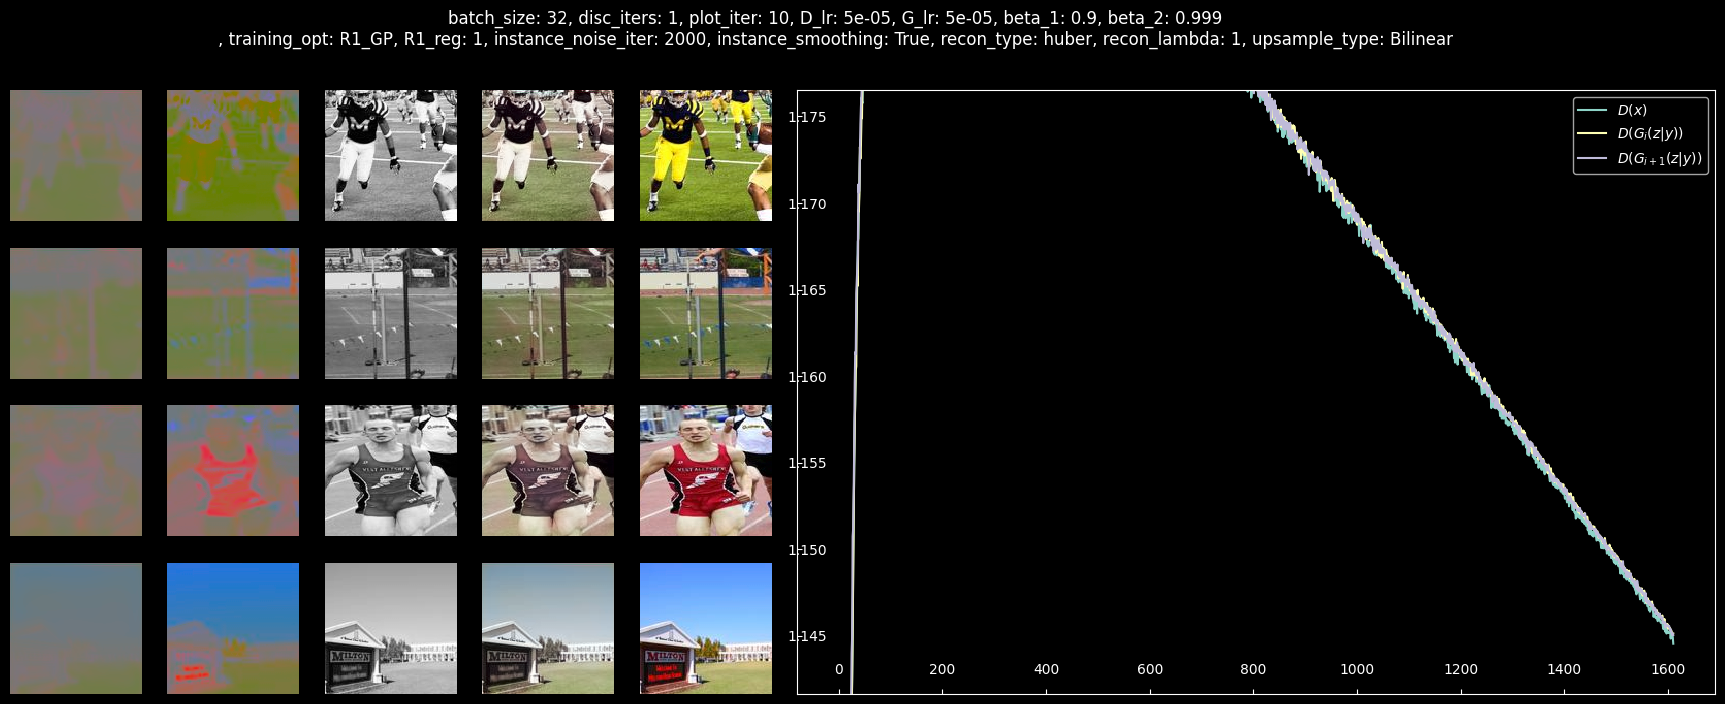

 27%|███████████████████████▊                                                               | 1376/5024 [02:49<07:29,  8.11img/s, Epoch: 10:1612, I.N.A.: 0.194, D.: 1.1446, G.i: 1.1450, G.i+1: 1.1449]


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(100):
  with tqdm(data_loader, unit_scale=batch_size, unit='img', ncols=200) as tqdm_bar:#, autocast():#
    for real in tqdm_bar:
      iteration += 1
      #https://arxiv.org/pdf/1610.04490.pdf & https://arxiv.org/pdf/1701.04862.pdf
      instance_noise_annealing = anneal(iteration,instance_noise_iter)

      real = real.to(device).requires_grad_(True)
      #gray = transforms.Grayscale(num_output_channels=1)(real).detach().clone()
      gray = real[:,:1]

      GNet.train()
      DNet.train()

      latent = torch.rand(real.size(0), 512, device=device)

      fake = GNet(gray, latent)

      #Training Discriminator
      DNet.zero_grad()

      if instance_smoothing:
        alpha = instance_noise_annealing*torch.rand(real.size(0),1,1,1, device=real.device).expand_as(real)
        real_input = (1-alpha) * real +  alpha * fake.detach()
      else:
        real_input = real

      real_noise = (instance_noise_annealing*np.sqrt(2*R1_reg/5))*torch.randn_like(real, device=device)

      disc_real = DNet(real_input+real_noise)

      Dreal_loss = F.softplus(-disc_real).mean()

      if instance_smoothing:
        alpha = instance_noise_annealing*torch.rand(real.size(0),1,1,1, device=real.device).expand_as(real)
        fake_input = alpha * real + (1-alpha) * fake.detach()
      else:
        fake_input = fake.detach()

      fake_noise = (instance_noise_annealing*np.sqrt(2*R1_reg/5))*torch.randn_like(real, device=device)

      disc_fake = DNet(fake_input + fake_noise)

      Dfake_loss = F.softplus(disc_fake).mean()

      #https://arxiv.org/pdf/1801.04406.pdf - R1 Reguilarization
      grad_penalty = 0.0
      if training_opt in ['R1_reg', 'R1_GP']:
        real_grad = torch.autograd.grad(outputs=disc_real.sum(), inputs=real, create_graph=True, only_inputs=True)[0]
        grad_penalty += (R1_reg / 2)*real_grad.view(real_grad.size(0), -1).square().sum(-1).mean()

      #https://arxiv.org/pdf/1704.00028.pdf afsnit 4 - gradient penalty
      if training_opt in ['GP', 'R1_GP']:
        alpha = torch.rand(real.size(0),1,1,1, device=real.device).expand_as(real)
        interp = alpha * real + (1-alpha) * fake.detach()
        disc_interp = DNet(interp)
        interp_grad = torch.autograd.grad(outputs=disc_interp.sum(), inputs=interp, create_graph=True, only_inputs=True)[0]
        grad_penalty += (R1_reg / 2)*interp_grad.view(interp_grad.size(0), -1).norm(2, dim=1).subtract(1.0).square().sum(-1).mean()

      D_loss = Dreal_loss + Dfake_loss + grad_penalty
      D_loss.backward()

      D_optimizer.step()

      #Training Generator
      GNet.zero_grad()

      #Train generator 1 time for every discriminator
      if iteration % disc_iters == 0:

        if instance_smoothing:
          alpha = instance_noise_annealing*torch.rand(real.size(0),1,1,1, device=real.device).expand_as(real)
          gen_input = alpha * real.detach() + (1-alpha) * fake
        else:
          gen_input = fake

        gen_noise = (instance_noise_annealing*np.sqrt(2*R1_reg/5))*torch.randn_like(real, device=device)


        disc_gen = DNet(gen_input+gen_noise)

        G_loss = F.softplus(-disc_gen).mean()#criterion(output, torch.full_like(output, 1.0, dtype=torch.float, device=device))

        recon_loss = 0
        if recon_type == 'mse':
          recon_loss = mse_loss_fn(fake[:,1:],real[:,1:])
        elif recon_type == 'huber':
          recon_loss = huber_loss_fn(fake[:,1:],real[:,1:])

        (G_loss+recon_lambda*recon_loss).backward()

      G_optimizer.step()

      with torch.no_grad():
        losss_print['D.'].append(disc_real.mean().item())
        losss_print['G.i'].append(disc_fake.mean().item())
        #losss_print['Div.'].append(0.5*disc_fake.mean().item()-0.5*disc_real.mean().item())
        losss_print['G.i+1'].append(disc_gen.mean().item())

        tqdm_bar.set_postfix_str(f"Epoch: {epoch}:{iteration}, I.N.A.: {instance_noise_annealing:.3f}, "
                     +", ".join([f"{ns}: {ls[-1]:.4f}" for ns, ls in losss_print.items()]))
        if iteration % plot_iter == 0:
          clear_output(wait=True)
          #evaluate
          fig, axs = plt.subplots(4,11,figsize=(22,8), dpi=100)
          gs = axs[0, 5].get_gridspec()
          for axs_y in axs[:, 5:]:
            for ax in axs_y:
              ax.remove()
          fig.suptitle(", ".join([f"{k}: {v}"+("\n" if (i+1) % 7 == 0 else "") for i,(k, v) in enumerate(hyper_params.items())]))
          axbig1 = fig.add_subplot(gs[:, 5:])
          axbig1.tick_params(direction='in', pad=-22)
          for axbig, losss in zip([axbig1], [losss_print]):
            legend = []
            #CI_upper = []
            #CI_lower = []
            for ns,ls in losss.items():
              axbig.plot(ls)
              legend.append(print_to_legend[ns])
              #mean = np.mean(ls)
              #CI_upper.append(max(mean+1.96*np.std(ls)/np.sqrt(len(ls)), max(ls[-50:])))
              #CI_lower.append(min(mean-1.96*np.std(ls)/np.sqrt(len(ls)), min(ls[-50:])))
            #y_lim_diff = max(CI_upper)-min(CI_lower)
            #axbig.set_ylim(top=max(CI_upper)+0.1*y_lim_diff, bottom=min(CI_lower)-0.1*y_lim_diff)
            axbig.legend(legend)
          im_pred_ = fake[:,-3:].cpu().detach()
          im_gray_ = gray.cpu().detach()
          im_true_ = real[:,-3:].cpu().detach()
          for i in range(4):
            axs[i][0].imshow(Lab2RGB(im_pred_[i].permute(1,2,0).float()*torch.tensor([0.0,1.0,1.0]).view(1,1,3)+torch.tensor([0.5,0.0,0.0]).view(1,1,3)), interpolation='nearest', aspect='equal', vmin=0, vmax=1)
            axs[i][1].imshow(Lab2RGB(im_true_[i].permute(1,2,0).float()*torch.tensor([0.0,1.0,1.0]).view(1,1,3)+torch.tensor([0.5,0.0,0.0]).view(1,1,3)), interpolation='nearest', aspect='equal', vmin=0, vmax=1)
            axs[i][2].imshow(im_gray_[i].permute(1,2,0).squeeze().float(), cmap='gray', interpolation='nearest', aspect='equal', vmin=0, vmax=1)
            axs[i][3].imshow(Lab2RGB(im_pred_[i].permute(1,2,0).float()), interpolation='nearest', aspect='equal', vmin=0, vmax=1)
            axs[i][4].imshow(Lab2RGB(im_true_[i].permute(1,2,0).float()), interpolation='nearest', aspect='equal', vmin=0, vmax=1)
            axs[i][0].set_axis_off()
            axs[i][1].set_axis_off()
            axs[i][2].set_axis_off()
            axs[i][3].set_axis_off()
            axs[i][4].set_axis_off()
          plt.show()

In [ ]:
torch.save({'gnet':GNet.state_dict(), 'dnet':DNet.state_dict(), 'D_opt':D_optimizer.state_dict(),'G_opt':D_optimizer.state_dict()}, 'save_athletic_field.h')